## 測試資料取得
取得測試相片以及測試用的相機參數

In [1]:
import cv2
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

def imshow(img):
    img2 = img[:, :, ::-1] #BGR2RGB
    plt.imshow(img2)
    plt.axis('off') #關閉坐標軸
    
    plt.show()

### 相機校正

In [3]:
# 創建ArUco校正板
def create_board(dictionary):
    board = cv2.aruco.CharucoBoard_create(3, 3, .025, .0125, dictionary)
    img = board.draw((200 * 3, 200 * 3))
    cv2.imwrite("board.png", img)
    
    return board

In [4]:
def read_chessboards(img, dictionary, board):
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, dictionary)
    
    if len(corners)>0:
        # SUB PIXEL DETECTION
        for corner in corners:
            cv2.cornerSubPix(gray, corner,
                             winSize = (3,3),
                             zeroZone = (-1,-1),
                             criteria = criteria)
        res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
    
        return res2, gray.shape

In [5]:
def calibrate_camera(allCorners,allIds,board, imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [6]:
dictionary = cv2.aruco.Dictionary_get(10)
board = create_board(dictionary)

# 創建視頻捕獲對象
capture = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
capture.set(cv2.CAP_PROP_FPS, 30)
capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"MJPG"))

allCorners = []
allIds = []
decimator = 0
while (decimator <= 20): # 擷取20張相片進行相機校正
    # 捕獲視頻幀
    ret, frame = capture.read()
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        res2, imsize = read_chessboards(frame, dictionary, board)
    
        if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
            allCorners.append(res2[1])
            allIds.append(res2[2])
        decimator+=1
# 銷毀窗口
capture.release()
cv2.destroyAllWindows()

ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,board, imsize)

if ret <= 3:
    np.savez('Camera_parameter.npz', mtx = mtx, dist = dist)
    print('Parameter is saved.')
else:
    print('Please calibrate camera again.')### 取得測試用照片

CAMERA CALIBRATION
Parameter is saved.


### 取得測試用照片

In [8]:
# 創建視頻捕獲對象
capture = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
capture.set(cv2.CAP_PROP_FPS, 30)
capture.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"MJPG"))

while True:
    # 捕獲視頻幀
    ret, frame = capture.read()
    
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite("test_img.png", frame)
        break
# 銷毀窗口
capture.release()
cv2.destroyAllWindows()

### 確認校正結果

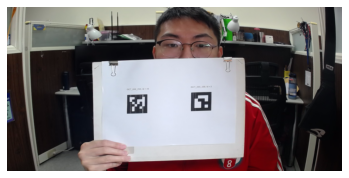

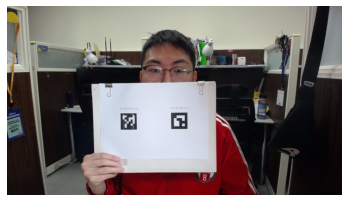

In [9]:
parameter = np.load('Camera_parameter.npz')
cameraMatrix = parameter['mtx']
distCoeffs = parameter['dist']

img = cv2.imread('test_img.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, (w,h), 1, (w,h))

# undistort
dst = cv2.undistort(img, cameraMatrix, distCoeffs, None, newcameramtx)

# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
imshow(dst)
imshow(img)